# Extract annotations and data from DrugBank

The purpose of this notebook is to extract and format Drug data for subsequent model annotation.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"uniprot"`
    * `"drugbank"`

## DRUGBANK ONLINE
To utilize this notebook: 

1. Go to [DrugBank database](https://go.drugbank.com/releases/latest) and create an account.
2. Follow the instructions to obtain a free academic license.
3. Download and unzip the database file `"drugbank_all_full_database.xml.zip"`.
4. Rename the file `"full database.xml"` to `"drugbank_all_full_database.xml"`.
5. Remember clear out any personal account information and ensure the downloaded DrugBank file remains local!

The function `download_database_DrugBank` takes a given username and a password and downloads the data, taking care to change the filename in the process.
*  Note: Requires internet connection to download information from [DrugBank](https://go.drugbank.com/).

Fields for the DrugBank XML schema are found [here](https://docs.drugbank.com/xml/#introduction).

### Citations
Wishart DS, Feunang YD, Guo AC, Lo EJ, Marcu A, Grant JR, Sajed T, Johnson D, Li C, Sayeeda Z, Assempour N, Iynkkaran I, Liu Y, Maciejewski A, Gale N, Wilson A, Chin L, Cummings R, Le D, Pon A, Knox C, Wilson M. DrugBank 5.0: a major update to the DrugBank database for 2018. Nucleic Acids Res. 2017 Nov 8. doi: 10.1093/nar/gkx1037.

## Setup
### Import packages

In [1]:
from collections import defaultdict
from warnings import warn
from xml.etree import ElementTree

import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    check_database_release_online,
    compare_tables,
    explode_column,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    show_versions,
    visualize_comparison,
)
from rbc_gem_utils.database.drugbank import (
    DRUGBANK_DB_TAG,
    DRUGBANK_GENERAL_ELEMENTS,
    DRUGBANK_NS,
    DRUGBANK_PATHWAY_ELEMENTS,
    DRUGBANK_RELEASE_EXPECTED,
    DRUGBANK_URL,
    download_database_DrugBank,
    strip_ns_DrugBank,
)
from rbc_gem_utils.util import has_value_type, strip_plural

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                 missing
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                              3.4.2
notebook                              7.4.2
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------------------
conda      25.3.1
pip          25.0
setuptools 78.1.1
wheel      0.45.1

Platform Information
-

## Set notebook options

In [2]:
db_tag = DRUGBANK_DB_TAG
expected_release = DRUGBANK_RELEASE_EXPECTED
database_url = DRUGBANK_URL
download_database = False

compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True

print_footer_notes = False

# Best mapping key is drugbank or uniprot
mapping_key = "uniprot"

## Check DrugBank release
* If the current release does not match the expected release, it is because database has been updated since the last time this code was utilized.
    * If the notebook works without needing any significant modifications, the only update needed is to the release in the [drugbank.py](../../src/rbc_gem_utils/database/drugbank.py) source code file to resolve the issue.
* Version in the DrugBank file is formatted as {major}.{minor}

In [3]:
use_interim = not check_database_release_online(
    db_tag,
    verbose=True,
)
# Use different directory paths for unexpected behavior
if use_interim:
    warn(
        "Online release of database has been updated since the last time notebook was used."
    )

database_dirpath = get_dirpath(
    "database", db_tag, use_temp="interim" if use_interim else None
)
annotation_dirpath = get_dirpath(
    "annotation", use_temp="interim" if use_interim else None
)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

Current and expected releases match. Current release: 5.1.13


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 
Username and password must be provided for this function, be sure to remove personal information after use!

In [4]:
if download_database:
    # Download data
    download_database_DrugBank(
        username="USERNAME",
        password="PASSWORD",
        database_dirpath=database_dirpath,
        release=current_release,
    )
filepath = database_dirpath / "drugbank_all_full_database.xml"

## Load RBC-GEM model

In [5]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Restricted license - for non-production use only - expires 2026-11-23


Name,RBC_GEM
Memory address,14bbf82c1a0
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Extract current annotations from model

In [6]:
annotation_type = "genes"
annotation_cols = ["uniprot", "drugbank"]

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)

for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)

uniprot_ids = set(df_model_mappings["uniprot"].dropna().unique())

df_model_mappings

genes        820
uniprot      820
drugbank    2712
dtype: int64


,genes,uniprot,drugbank
0,A4GALT,Q9NPC4,<NA>
1,AARS1,P49588,DB00160
2,AASDHPPT,Q9NRN7,<NA>
3,ABCA1,O95477,DB00163
4,ABCA1,O95477,DB00171
...,...,...,...
5270,YES1,P07947,DB12010
5271,ZDHHC2,Q9UIJ5,<NA>
5272,ZDHHC20,Q5W0Z9,<NA>
5273,ZDHHC3,Q9NYG2,<NA>


#### Get query IDs

In [7]:
print(f"Mapping key: {mapping_key}")
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Mapping key: uniprot
Number of model genes associated with query: 820
Number of unique IDs to query: 820


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
9,ABCA7,Q8IZY2
...,...,...
5269,YES1,P07947
5271,ZDHHC2,Q9UIJ5
5272,ZDHHC20,Q5W0Z9
5273,ZDHHC3,Q9NYG2


## Parse DrugBank information for annotations into DataFrames

In [8]:
root = ElementTree.parse(filepath).getroot()
root

<Element '{http://www.drugbank.ca}drugbank' at 0x0000014BC0E14130>

### Extract proteins

In [9]:
idx = 0
data = defaultdict(dict)
prefix = True
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    prefix = f"proteins."
    for ptype in ["targets", "enzymes", "carriers", "transporters"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{ptype}/{DRUGBANK_NS}{strip_plural(ptype)}"
        )
        for element in elements:
            for subelement in element.findall(f"{DRUGBANK_NS}polypeptide"):
                data[idx].update({f"drugbank-id": drugbank_id, f"{prefix}type": ptype})
                data[idx].update(
                    {
                        f"{prefix}{strip_ns_DrugBank(subelement.tag)}": subelement.text
                        for subelement in element
                        if has_value_type(subelement)
                    }
                )

                # Polypeptide
                key = "polypeptide"
                data[idx].update(
                    {
                        f"{prefix}{key}.uniprot-id": subelement.get("id"),
                        f"{prefix}{key}.source": subelement.get("source"),
                    }
                )
                data[idx].update(
                    {
                        f"{prefix}{key}.{strip_ns_DrugBank(subelem.tag)}": subelem.text
                        for subelem in subelement
                        if has_value_type(subelem)
                    }
                )
                subkey = "pfams"
                data[idx].update(
                    {
                        f"{prefix}{key}.{subkey}": build_string(
                            [
                                subelem.text
                                for subelem in subelement.findall(
                                    f"{DRUGBANK_NS}{subkey}/{DRUGBANK_NS}{strip_plural(subkey)}/{DRUGBANK_NS}identifier"
                                )
                                if has_value_type(subelem)
                            ]
                        )
                    }
                )

                idx += 1

df_drugs_proteins_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_drugs_protein_data = df_drugs_proteins_data[
    df_drugs_proteins_data["proteins.polypeptide.uniprot-id"].isin(uniprot_ids)
]
df_model_drugs_protein_data = df_model_drugs_protein_data.drop_duplicates().reset_index(
    drop=True
)
if display_nunique:
    print(df_model_drugs_protein_data.nunique(dropna=True))
df_model_drugs_protein_data.head()

drugbank-id                                   2712
proteins.type                                    4
proteins.id                                    502
proteins.name                                  502
proteins.organism                                3
proteins.known-action                            3
proteins.polypeptide.uniprot-id                478
proteins.polypeptide.source                      1
proteins.polypeptide.name                      478
proteins.polypeptide.general-function          465
proteins.polypeptide.specific-function         247
proteins.polypeptide.gene-name                 478
proteins.polypeptide.locus                     296
proteins.polypeptide.cellular-location          43
proteins.polypeptide.signal-regions             17
proteins.polypeptide.theoretical-pi            243
proteins.polypeptide.molecular-weight          478
proteins.polypeptide.chromosome-location        24
proteins.polypeptide.organism                    1
proteins.polypeptide.amino-acid

,drugbank-id,proteins.type,proteins.id,proteins.name,proteins.organism,proteins.known-action,proteins.polypeptide.uniprot-id,proteins.polypeptide.source,proteins.polypeptide.name,proteins.polypeptide.general-function,...,proteins.polypeptide.theoretical-pi,proteins.polypeptide.molecular-weight,proteins.polypeptide.chromosome-location,proteins.polypeptide.organism,proteins.polypeptide.amino-acid-sequence,proteins.polypeptide.gene-sequence,proteins.polypeptide.pfams,proteins.polypeptide.transmembrane-regions,proteins.inhibition-strength,proteins.induction-strength
0,DB00006,enzymes,BE0001075,Myeloperoxidase,Humans,unknown,P05164,Swiss-Prot,Myeloperoxidase,Part of the host defense system of polymorphon...,...,9.14,83867.71,17,Humans,>lcl|BSEQ0002139|Myeloperoxidase\nMGVPFFSSLRCM...,>lcl|BSEQ0016304|Myeloperoxidase (MPO)\nATGGGG...,PF03098,,unknown,
1,DB00027,transporters,BE0001032,ATP-dependent translocase ABCB1,Humans,unknown,P08183,Swiss-Prot,ATP-dependent translocase ABCB1,Translocates drugs and phospholipids across th...,...,9.44,141477.255,7,Humans,>lcl|BSEQ0037114|ATP-dependent translocase ABC...,>lcl|BSEQ0016291|Multidrug resistance protein ...,PF00005;PF00664,45-67\n117-137\n187-208\n216-236\n293-316\n331...,,
2,DB00030,targets,BE0000033,Insulin receptor,Humans,yes,P06213,Swiss-Prot,Insulin receptor,Receptor tyrosine kinase which mediates the pl...,...,6.18,156331.465,19,Humans,>lcl|BSEQ0036940|Insulin receptor\nMATGGRRGAAA...,>lcl|BSEQ0020443|Insulin receptor (INSR)\nATGG...,PF00757;PF01030;PF17870;PF00041;PF07714,957-979,,
3,DB00035,enzymes,BE0000262,Prostaglandin G/H synthase 2,Humans,unknown,P35354,Swiss-Prot,Prostaglandin G/H synthase 2,Dual cyclooxygenase and peroxidase in the bios...,...,7.41,68995.625,1,Humans,>lcl|BSEQ0021832|Prostaglandin G/H synthase 2\...,>lcl|BSEQ0021833|Prostaglandin G/H synthase 2 ...,PF03098,,,unknown
4,DB00035,enzymes,BE0000017,Prostaglandin G/H synthase 1,Humans,unknown,P23219,Swiss-Prot,Prostaglandin G/H synthase 1,Dual cyclooxygenase and peroxidase that plays ...,...,7.39,68685.82,9,Humans,>lcl|BSEQ0036935|Prostaglandin G/H synthase 1\...,>lcl|BSEQ0021254|Prostaglandin G/H synthase 1 ...,PF03098,,,unknown


### Extract SNPs associated with drugs

In [10]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    for key in ["snp-effects", "snp-adverse-drug-reactions"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key.split('-')[-1])}"
        )
        for element in elements:
            data[idx].update({"drugbank-id": drugbank_id})
            data[idx].update(
                {
                    f"{strip_ns_DrugBank(subelement.tag)}": subelement.text
                    for subelement in element
                    if has_value_type(subelement)
                }
            )
            idx += 1
df_snp_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_snp_data = (
    df_snp_data[df_snp_data["uniprot-id"].isin(uniprot_ids)]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_snp_data = (
    df_model_snp_data.drop_duplicates()
    .sort_values("gene-symbol")
    .reset_index(drop=True)
)
if display_nunique:
    print(df_model_snp_data.nunique(dropna=True))
df_model_snp_data.head()

drugbank-id         19
protein-name         8
gene-symbol          8
uniprot-id           8
rs-id               18
defining-change      8
description         27
pubmed-id           18
adverse-reaction    11
allele              11
dtype: int64


,drugbank-id,protein-name,gene-symbol,uniprot-id,rs-id,defining-change,description,pubmed-id,adverse-reaction,allele
0,DB00215,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,C Allele,Patients with this genotype have an increased ...,17913323,NaN,NaN
1,DB01233,Multidrug resistance protein 1,ABCB1,P08183,rs1045642,T Allele,Patients with this polymorphism in ABCB1 may h...,21840870,NaN,NaN
2,DB00864,Multidrug resistance protein 1,ABCB1,P08183,rs2032582,NaN,The presence of this genotype in ABCB1 may ind...,12352921,T Allele (G2677T),NaN
3,DB00448,Multidrug resistance protein 1,ABCB1,P08183,rs1045642,"C Allele, heterozygote",Patients with this genotype have increased pla...,17190370,NaN,NaN
4,DB00321,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,T > C,Patients with this genotype have increased ris...,22641028,NaN,NaN


### Extract pathways associated with drugs

In [11]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    key = "pathways"
    elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
    for element in elements:
        data[idx].update({"drugbank-id": drugbank_id})
        for subkey in DRUGBANK_PATHWAY_ELEMENTS:
            if subkey in {"smpdb-id", "name", "category"}:
                data[idx].update(
                    {f"{subkey}": element.findtext(f"{DRUGBANK_NS}{subkey}")}
                )
            elif subkey == "drugs":
                # All drugbank IDs in this field will be redundant
                # as long as they also appear in the original drugbank ID column
                continue
            else:
                data[idx].update(
                    {
                        f"uniprot-id": build_string(
                            [
                                subelem.text
                                for subelem in element.findall(
                                    f"{DRUGBANK_NS}{subkey}/{DRUGBANK_NS}uniprot-id"
                                )
                            ]
                        )
                    }
                )

        idx += 1

df_pathways_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_pathways_data = explode_column(df_pathways_data, name="uniprot-id", sep=";")
df_pathways_data = df_pathways_data[
    df_pathways_data["uniprot-id"].isin(uniprot_ids)
].reset_index(drop=True)
if display_nunique:
    print(df_pathways_data.nunique(dropna=True))
df_pathways_data.head()

drugbank-id    533
smpdb-id       681
name           677
category         6
uniprot-id     302
dtype: int64


,drugbank-id,smpdb-id,name,category,uniprot-id
0,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,Q15758
1,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P43007
2,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P24298
3,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P00505
4,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P05089


### Combine and format annotations

genes: 478
uniprot: 478
drugbank: 2712
pfam: 500
hgnc.symbol: 478
dbsnp: 18
smpdb: 648


,genes,uniprot,drugbank,pfam,hgnc.symbol,dbsnp,smpdb
0,AARS1,P49588,DB00160,PF01411;PF02272;PF07973,AARS1,<NA>,SMP0000055;SMP0000313;SMP0000350;SMP0000352
1,ABCA1,O95477,DB00163;DB00171;DB00675;DB01016;DB01599;DB11635,PF00005;PF12698,ABCA1,<NA>,<NA>
2,ABCB1,P08183,DB00027;DB00052;DB00080;DB00091;DB00104;DB0017...,PF00005;PF00664,ABCB1,rs1045642;rs2032582;rs2032583,SMP0000260;SMP0000433;SMP0000434;SMP0000435;SM...
3,ABCB4,P21439,DB06191;DB06207;DB06414;DB12799;DB14068;DB14070,PF00005;PF00664,ABCB4,<NA>,<NA>
4,ABCC1,P33527,DB00115;DB00143;DB00171;DB00224;DB00286;DB0032...,PF00005;PF00664,ABCC1,<NA>,SMP0000433;SMP0000434;SMP0000435;SMP0000436;SM...
...,...,...,...,...,...,...,...
473,VDAC2,P45880,DB01375;DB06098,PF01459,VDAC2,<NA>,<NA>
474,VDAC3,Q9Y277,DB01375;DB06098,PF01459,VDAC3,<NA>,<NA>
475,WARS1,P23381,DB00150;DB01831;DB04537,PF00458;PF00579,WARS1,<NA>,SMP0000063
476,YARS1,P54577,DB00135;DB01766;DB02709;DB03978;DB07205;DB0837...,PF00579;PF01588,YARS1,<NA>,SMP0000008;SMP0000206;SMP0000369;SMP0000370


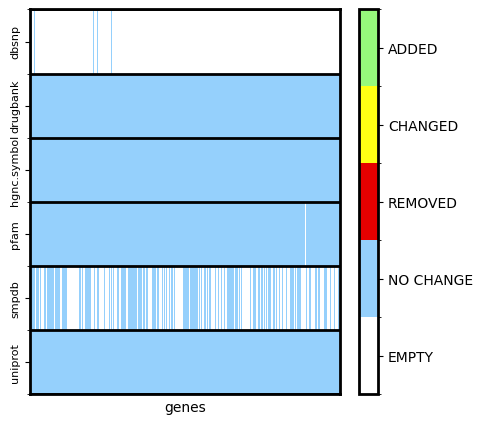

In [12]:
rename_mapping = {
    "drugbank-id": "drugbank",
    "proteins.polypeptide.uniprot-id": "uniprot",
    "proteins.polypeptide.pfams": "pfam",
    "proteins.polypeptide.gene-name": "hgnc.symbol",
    "gene-symbol": "hgnc.symbol",
    "drugbank-id": "drugbank",
    "uniprot-id": "uniprot",
    "rs-id": "dbsnp",
    "drugbank-id": "drugbank",
    "uniprot-id": "uniprot",
    "smpdb-id": "smpdb",
    "ndc-product-code": "ndc",
    "dpd-id": "cdpd",
}
# Start with protein data
df = df_model_drugs_protein_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df.drop_duplicates()

# Add SNP data
df = df_model_snp_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df_annotations.merge(
    df,
    left_on="uniprot",
    right_on="uniprot",
    suffixes=("", "_drop"),
    how="left",
).drop_duplicates()

# Add Pathway data
df = df_pathways_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df_annotations.merge(
    df,
    left_on="uniprot",
    right_on="uniprot",
    suffixes=("", "_drop"),
    how="left",
).drop_duplicates()

# # Add product data
# df = df_products_data
# df = df.loc[:, [x for x in rename_mapping if x in df.columns]].rename(rename_mapping, axis=1).drop_duplicates()
# df_annotations = df_annotations.merge(
#     df,
#     left_on="uniprot",
#     right_on="uniprot",
#     suffixes=("", "_drop"),
#     how="left",
# ).drop_duplicates()


df_annotations = df_annotations.drop(
    labels=[col for col in df_annotations.columns if col.endswith("_drop")], axis=1
).drop_duplicates()
df_annotations = explode_column(df_annotations, "pfam", sep=";")
df_annotations = df_annotations.drop_duplicates().replace("", pd.NA)
df_annotations = (
    df_annotations.groupby("uniprot", as_index=False)
    .agg(lambda x: build_string(sorted(x.dropna().unique())))
    .replace("", pd.NA)
)
df_annotations = pd.merge(
    df_model_mappings[[annotation_type, mapping_key]].drop_duplicates(),
    df_annotations,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)
df_annotations = (
    df_annotations.sort_values("genes")
    .dropna(subset=["drugbank"])
    .reset_index(drop=True)
)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations

## Extract data from DrugBank into DataFrames

In [13]:
all_drug_dfs = {}
df_mappings = df_annotations[["genes", "uniprot", "drugbank"]].copy()
df_mappings["drugbank"] = df_mappings["drugbank"].str.split(";")
df_mappings = df_mappings.explode("drugbank").drop_duplicates()
print(df_mappings.nunique())
drugbank_ids = set(df_mappings["drugbank"].dropna().unique())
uniprot_ids = set(df_mappings["uniprot"].dropna().unique())
df_mappings

genes        478
uniprot      478
drugbank    2712
dtype: int64


,genes,uniprot,drugbank
0,AARS1,P49588,DB00160
1,ABCA1,O95477,DB00163
1,ABCA1,O95477,DB00171
1,ABCA1,O95477,DB00675
1,ABCA1,O95477,DB01016
...,...,...,...
476,YARS1,P54577,DB07205
476,YARS1,P54577,DB08371
476,YARS1,P54577,DB08617
477,YES1,P07947,DB01254


### Extract general information

In [14]:
idx = 0
data = defaultdict(dict)
for drug in root:
    # General information
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    # Get only drugbank IDs specified
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    data[idx].update({"drugbank-id": drugbank_id})
    data[idx].update({attr: drug.get(attr) for attr in ["type", "created", "updated"]})
    for key in DRUGBANK_GENERAL_ELEMENTS:
        if key == "drugbank-id":
            continue

        if key in {"name", "cas-number"}:
            element = drug.find(f"{DRUGBANK_NS}{key}")
            if element is not None and has_value_type(element):
                data[idx].update({key: element.text})

    for key in {"products", "international-brands"}:
        subkey = "name"
        data[idx].update(
            {
                f"{key}": build_string(
                    [
                        element.findtext(f"{DRUGBANK_NS}{subkey}")
                        for element in drug.findall(
                            f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}"
                        )
                    ]
                )
            }
        )
    key = "synonyms"
    data[idx].update(
        {
            f"{key}": build_string(
                [
                    element.text
                    for element in drug.findall(
                        f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}"
                    )
                ]
            )
        }
    )

    idx += 1

df_drugbank_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
all_drug_dfs["General"] = df_drugbank_data
df_drugbank_data = df_drugbank_data.drop(["created", "updated"], axis=1)
df_drugbank_data

,drugbank-id,type,name,cas-number,products,international-brands,synonyms
0,DB00006,small molecule,Bivalirudin,128270-60-0,Angiomax;Angiomax RTU;Angiox;Bivalirudin;Bival...,Angiox;Hirulog,Bivalirudin;Bivalirudina;Bivalirudinum
1,DB00027,small molecule,Gramicidin D,1405-97-6,Antibiotic Cream;Antibiotic Cream for Kids;Ant...,Sofradex,Bacillus brevis gramicidin D;Gramicidin;Gramic...
2,DB00030,biotech,Insulin human,11061-68-0,Actraphane 30;Actraphane 30 Flexpen;Actraphane...,,High molecular weight insulin human;Human insu...
3,DB00035,small molecule,Desmopressin,16679-58-6,Apo-desmopressin;Bipazen;Ddavp;Ddavp Inj 4mcg/...,Adiuretin;DesmoMelt,1-(3-mercaptopropionic acid)-8-D-arginine-vaso...
4,DB00041,biotech,Aldesleukin,110942-02-4,Proleukin,,125-L-serine-2-133-interleukin 2 (human reduce...
...,...,...,...,...,...,...,...
2707,DB19169,small molecule,Pamapimod,449811-01-2,,,"6-(2,4-Difluorophenoxy)-2-{[3-hydroxy-1-(2-hyd..."
2708,DB19170,small molecule,Pemrametostat,1616392-22-3,,,"4-pyrimidinecarboxamide, 6-((1-acetyl-4-piperi..."
2709,DB19281,small molecule,Licochalcone A,58749-22-7,,,"(2e)-3-(5-(1,1-dimethyl-2-propenyl)-4-hydroxy-..."
2710,DB19283,small molecule,Honokiol,35354-74-6,,,"(1,1'-biphenyl)-2,4'-diol, 3',5-di-2-propen-1-..."


### Extract drug categories and Mesh IDs

In [15]:
idx = 0
data = defaultdict(dict)
for drug in root:
    # General information
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    # Get only drugbank IDs specified
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    key = "categories"
    # Drug catgories
    # For mesh-id: https://registry.identifiers.org/registry/mesh
    elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
    for element in elements:
        data[idx].update({"drugbank-id": drugbank_id})
        data[idx]["category"] = element.findtext(f"{DRUGBANK_NS}category")
        data[idx]["mesh-id"] = element.findtext(f"{DRUGBANK_NS}mesh-id")
        idx += 1


df_drug_category = (
    pd.DataFrame.from_dict(data, orient="index")
    .replace("", float("nan"))
    .drop_duplicates()
    .reset_index(drop=True)
)
all_drug_dfs["Categories"] = df_drug_category
df_drug_category

,drugbank-id,category,mesh-id
0,DB00006,"Amino Acids, Peptides, and Proteins",D000602
1,DB00006,Anticoagulants,D000925
2,DB00006,Antithrombins,D000991
3,DB00006,Blood and Blood Forming Organs,NaN
4,DB00006,Enzyme Inhibitors,D004791
...,...,...,...
32561,DB19353,Cytochrome P-450 CYP3A Substrates,NaN
32562,DB19353,Cytochrome P-450 CYP3A4 Substrates,NaN
32563,DB19353,Cytochrome P-450 Substrates,NaN
32564,DB19353,"Heterocyclic Compounds, Fused-Ring",D000072471


### Extract ATC codes

In [16]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    # Get only drugbank IDs specified
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    key = "atc-codes"
    elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
    for element in elements:
        data[idx].update(
            {
                "drugbank-id": drugbank_id,
                "substance.code": element.get("code"),
                "substance.description": drug.findtext(f"{DRUGBANK_NS}name"),
            }
        )
        for level, subelement in zip(
            ["chemical", "pharmacological", "therapeutic", "anatomical"], list(element)
        ):
            data[idx].update(
                {
                    f"{level}.description": subelement.text,
                    f"{level}.code": subelement.get("code"),
                }
            )
        idx += 1

df_atc_codes_data = pd.DataFrame.from_dict(data, orient="index")
df_atc_codes_data = df_atc_codes_data.loc[
    :, list(df_atc_codes_data.columns[:1]) + list(df_atc_codes_data.columns[1:][::-1])
]
df_atc_codes_data = (
    df_drugbank_data[["drugbank-id"]]
    .merge(
        df_atc_codes_data,
        left_on="drugbank-id",
        right_on="drugbank-id",
        how="left",
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
all_drug_dfs["ATC"] = df_atc_codes_data

print(df_atc_codes_data.nunique())
df_atc_codes_data

drugbank-id                    2712
anatomical.code                  14
anatomical.description           14
therapeutic.code                 85
therapeutic.description          85
pharmacological.code            204
pharmacological.description     200
chemical.code                   540
chemical.description            498
substance.description          1061
substance.code                 1927
dtype: int64


,drugbank-id,anatomical.code,anatomical.description,therapeutic.code,therapeutic.description,pharmacological.code,pharmacological.description,chemical.code,chemical.description,substance.description,substance.code
0,DB00006,B,BLOOD AND BLOOD FORMING ORGANS,B01,ANTITHROMBOTIC AGENTS,B01A,ANTITHROMBOTIC AGENTS,B01AE,Direct thrombin inhibitors,Bivalirudin,B01AE06
1,DB00027,R,RESPIRATORY SYSTEM,R02,THROAT PREPARATIONS,R02A,THROAT PREPARATIONS,R02AB,Antibiotics,Gramicidin D,R02AB30
2,DB00030,A,ALIMENTARY TRACT AND METABOLISM,A10,DRUGS USED IN DIABETES,A10A,INSULINS AND ANALOGUES,A10AC,"Insulins and analogues for injection, intermed...",Insulin human,A10AC01
3,DB00030,A,ALIMENTARY TRACT AND METABOLISM,A10,DRUGS USED IN DIABETES,A10A,INSULINS AND ANALOGUES,A10AE,"Insulins and analogues for injection, long-acting",Insulin human,A10AE01
4,DB00030,A,ALIMENTARY TRACT AND METABOLISM,A10,DRUGS USED IN DIABETES,A10A,INSULINS AND ANALOGUES,A10AB,"Insulins and analogues for injection, fast-acting",Insulin human,A10AB01
...,...,...,...,...,...,...,...,...,...,...,...
3849,DB19169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3850,DB19170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3851,DB19281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3852,DB19283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extract drug interactions
Extracted drug interactions are confined to those that directly map into the reconstruction.

In [17]:
prefix = True

idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    # Get only drugbank IDs specified
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    key = "drug-interactions"
    elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
    prefix = f"{key}." if prefix else ""
    for element in elements:
        interacting_id = element.findtext(f"{DRUGBANK_NS}drugbank-id")
        if interacting_id in drugbank_ids:
            data[idx].update(
                {
                    "drugbank-id": drugbank_id,
                    "name": drug.findtext(f"{DRUGBANK_NS}name"),
                }
            )
            data[idx].update(
                {
                    f"{prefix}{subkey}": element.findtext(f"{DRUGBANK_NS}{subkey}")
                    for subkey in ["drugbank-id", "name", "description"]
                }
            )
            idx += 1

df_drug_interactions = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)

# Drug interactions go two ways, generate a field to keep only unique interactions
df_drug_interactions["drug;drug"] = df_drug_interactions[
    ["drugbank-id", "drug-interactions.drugbank-id"]
].apply(lambda x: build_string(sorted(x.values)), axis=1)
df_drug_interactions = df_drug_interactions.drop_duplicates(subset=["drug;drug"])
df_drug_interactions = df_drug_interactions.reset_index(drop=True)
df_drug_interactions = df_drug_interactions.rename(
    {
        "drugbank-id": "drugbank_A",
        "name": "name_A",
        "drug-interactions.drugbank-id": "drugbank_B",
        "drug-interactions.name": "name_B",
        "drug;drug": "drugbank_A;drugbank_B",
    },
    axis=1,
)
all_drug_dfs["Interactions"] = df_drug_interactions

print(df_drug_interactions.nunique())
df_drug_interactions

drugbank_A                         1239
name_A                             1239
drugbank_B                         1267
name_B                             1267
drug-interactions.description    247317
drugbank_A;drugbank_B            247317
dtype: int64


,drugbank_A,name_A,drugbank_B,name_B,drug-interactions.description,drugbank_A;drugbank_B
0,DB00006,Bivalirudin,DB06605,Apixaban,Apixaban may increase the anticoagulant activi...,DB00006;DB06605
1,DB00006,Bivalirudin,DB06695,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...,DB00006;DB06695
2,DB00006,Bivalirudin,DB01254,Dasatinib,The risk or severity of bleeding and hemorrhag...,DB00006;DB01254
3,DB00006,Bivalirudin,DB01586,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...,DB00006;DB01586
4,DB00006,Bivalirudin,DB02123,Glycochenodeoxycholic Acid,The risk or severity of bleeding and bruising ...,DB00006;DB02123
...,...,...,...,...,...,...
247312,DB16703,Belumosudil,DB17472,Pirtobrutinib,The risk or severity of adverse effects can be...,DB16703;DB17472
247313,DB16703,Belumosudil,DB16826,Repotrectinib,The serum concentration of Repotrectinib can b...,DB16703;DB16826
247314,DB16826,Repotrectinib,DB17472,Pirtobrutinib,The serum concentration of Repotrectinib can b...,DB16826;DB17472
247315,DB16826,Repotrectinib,DB16956,L-Acetylleucine,The serum concentration of Repotrectinib can b...,DB16826;DB16956


### Extract protein data

In [18]:
idx = 0
data = defaultdict(dict)
prefix = False
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    prefix = f"proteins." if prefix else ""
    for ptype in ["targets", "enzymes", "carriers", "transporters"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{ptype}/{DRUGBANK_NS}{strip_plural(ptype)}"
        )
        for element in elements:
            for subelement in element.findall(f"{DRUGBANK_NS}polypeptide"):
                data[idx].update({f"drugbank-id": drugbank_id, f"{prefix}type": ptype})
                data[idx].update(
                    {
                        f"{prefix}{strip_ns_DrugBank(subelement.tag)}": subelement.text
                        for subelement in element
                        if has_value_type(subelement)
                    }
                )

                # Polypeptide
                key = "polypeptide"
                data[idx].update(
                    {
                        f"{prefix}{key}.uniprot-id": subelement.get("id"),
                        f"{prefix}{key}.source": subelement.get("source"),
                    }
                )
                data[idx].update(
                    {
                        f"{prefix}{key}.{strip_ns_DrugBank(subelem.tag)}": subelem.text
                        for subelem in subelement
                        if has_value_type(subelem)
                    }
                )
                subkey = "pfams"
                data[idx].update(
                    {
                        f"{prefix}{key}.{subkey}": build_string(
                            [
                                subelem.text
                                for subelem in subelement.findall(
                                    f"{DRUGBANK_NS}{subkey}/{DRUGBANK_NS}{strip_plural(subkey)}/{DRUGBANK_NS}identifier"
                                )
                                if has_value_type(subelem)
                            ]
                        )
                    }
                )

                idx += 1

df_proteins = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_proteins = df_proteins[
    df_proteins[f"{prefix}polypeptide.uniprot-id"].isin(uniprot_ids)
]
df_proteins = df_proteins.drop_duplicates().reset_index(drop=True)
df_proteins = (
    df_mappings[["genes", "uniprot"]]
    .merge(df_proteins, left_on="uniprot", right_on="polypeptide.uniprot-id")
    .drop_duplicates()
    .drop(["uniprot"], axis=1)
    .reset_index(drop=True)
)

all_drug_dfs["Proteins"] = df_proteins
df_proteins

,genes,drugbank-id,type,id,name,organism,known-action,polypeptide.uniprot-id,polypeptide.source,polypeptide.name,...,polypeptide.theoretical-pi,polypeptide.molecular-weight,polypeptide.chromosome-location,polypeptide.organism,polypeptide.amino-acid-sequence,polypeptide.gene-sequence,polypeptide.pfams,inhibition-strength,polypeptide.transmembrane-regions,induction-strength
0,AARS1,DB00160,targets,BE0000294,"Alanine--tRNA ligase, cytoplasmic",Humans,unknown,P49588,Swiss-Prot,"Alanine--tRNA ligase, cytoplasmic",...,5.18,106809.525,16,Humans,">lcl|BSEQ0000585|Alanine--tRNA ligase, cytopla...",">lcl|BSEQ0010066|Alanine--tRNA ligase, cytopla...",PF07973;PF01411;PF02272,,,
1,ABCA1,DB00163,transporters,BE0000119,Phospholipid-transporting ATPase ABCA1,Humans,unknown,O95477,Swiss-Prot,Phospholipid-transporting ATPase ABCA1,...,6.84,254299.89,9,Humans,>lcl|BSEQ0036954|Phospholipid-transporting ATP...,>lcl|BSEQ0009947|ATP-binding cassette sub-fami...,PF00005;PF12698,,22-42\n640-660\n683-703\n716-736\n745-765\n777...,
2,ABCA1,DB00171,targets,BE0000119,Phospholipid-transporting ATPase ABCA1,Humans,unknown,O95477,Swiss-Prot,Phospholipid-transporting ATPase ABCA1,...,6.84,254299.89,9,Humans,>lcl|BSEQ0036954|Phospholipid-transporting ATP...,>lcl|BSEQ0009947|ATP-binding cassette sub-fami...,PF00005;PF12698,,22-42\n640-660\n683-703\n716-736\n745-765\n777...,
3,ABCA1,DB00675,transporters,BE0000119,Phospholipid-transporting ATPase ABCA1,Humans,unknown,O95477,Swiss-Prot,Phospholipid-transporting ATPase ABCA1,...,6.84,254299.89,9,Humans,>lcl|BSEQ0036954|Phospholipid-transporting ATP...,>lcl|BSEQ0009947|ATP-binding cassette sub-fami...,PF00005;PF12698,,22-42\n640-660\n683-703\n716-736\n745-765\n777...,
4,ABCA1,DB01016,targets,BE0000119,Phospholipid-transporting ATPase ABCA1,Humans,unknown,O95477,Swiss-Prot,Phospholipid-transporting ATPase ABCA1,...,6.84,254299.89,9,Humans,>lcl|BSEQ0036954|Phospholipid-transporting ATP...,>lcl|BSEQ0009947|ATP-binding cassette sub-fami...,PF00005;PF12698,,22-42\n640-660\n683-703\n716-736\n745-765\n777...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,YARS1,DB07205,targets,BE0000230,"Tyrosine--tRNA ligase, cytoplasmic",Humans,unknown,P54577,Swiss-Prot,"Tyrosine--tRNA ligase, cytoplasmic",...,7.05,59143.025,1,Humans,">lcl|BSEQ0036975|Tyrosine--tRNA ligase, cytopl...",">lcl|BSEQ0010211|Tyrosine--tRNA ligase, cytopl...",PF00579;PF01588,,,
5034,YARS1,DB08371,targets,BE0000230,"Tyrosine--tRNA ligase, cytoplasmic",Humans,unknown,P54577,Swiss-Prot,"Tyrosine--tRNA ligase, cytoplasmic",...,7.05,59143.025,1,Humans,">lcl|BSEQ0036975|Tyrosine--tRNA ligase, cytopl...",">lcl|BSEQ0010211|Tyrosine--tRNA ligase, cytopl...",PF00579;PF01588,,,
5035,YARS1,DB08617,targets,BE0000230,"Tyrosine--tRNA ligase, cytoplasmic",Humans,unknown,P54577,Swiss-Prot,"Tyrosine--tRNA ligase, cytoplasmic",...,7.05,59143.025,1,Humans,">lcl|BSEQ0036975|Tyrosine--tRNA ligase, cytopl...",">lcl|BSEQ0010211|Tyrosine--tRNA ligase, cytopl...",PF00579;PF01588,,,
5036,YES1,DB01254,targets,BE0000840,Tyrosine-protein kinase Yes,Humans,yes,P07947,Swiss-Prot,Tyrosine-protein kinase Yes,...,6.71,60800.78,18,Humans,>lcl|BSEQ0010592|Tyrosine-protein kinase Yes\n...,>lcl|BSEQ0010593|Tyrosine-protein kinase Yes (...,PF00018;PF07714;PF00017,,,


### Extract drug associations with SNPs

In [19]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    if drugbank_ids and drugbank_id not in drugbank_ids:
        continue
    # Get only drugbank IDs specified
    for key in ["snp-effects", "snp-adverse-drug-reactions"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key.split('-')[-1])}"
        )
        for element in elements:
            data[idx].update({"drugbank-id": drugbank_id})
            data[idx].update(
                {
                    f"{strip_ns_DrugBank(subelement.tag)}": subelement.text
                    for subelement in element
                    if has_value_type(subelement)
                }
            )
            idx += 1
df_snp_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_snp_data = df_snp_data[df_snp_data["uniprot-id"].isin(uniprot_ids)]
df_snp_data = df_snp_data.drop_duplicates().reset_index(drop=True)
all_drug_dfs["SNP"] = df_snp_data

df_snp_data

,drugbank-id,protein-name,gene-symbol,uniprot-id,rs-id,defining-change,description,pubmed-id,allele,adverse-reaction
0,DB00215,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,C Allele,Patients with this genotype have an increased ...,17913323,,
1,DB00285,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,C Allele,Patients with this genotype have an increased ...,17913323,,
2,DB00285,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,T > C,Patients with this genotype have increased ris...,22641028,,
3,DB00295,Multidrug resistance protein 1,ABCB1,P08183,rs1045642,T Allele,Patients with this genotype may have an increa...,17898703,,
4,DB00317,ATP-binding cassette sub-family G member 2,ABCG2,Q9UNQ0,rs2231142,,Patients with this genotype have an increased ...,17148776,,A allele
5,DB00321,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,C Allele,Patients with this genotype have an increased ...,17913323,,
6,DB00321,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,T > C,Patients with this genotype have increased ris...,22641028,,
7,DB00352,Thiopurine S-methyltransferase,TPMT,P51580,rs1800462,,The presence of this polymorphism in TPMT may ...,21270794,TPMT*2,G Allele
8,DB00352,Thiopurine S-methyltransferase,TPMT,P51580,rs1800460,,The presence of this polymorphism in TPMT may ...,21270794,TPMT*3A,A Allele
9,DB00352,Thiopurine S-methyltransferase,TPMT,P51580,rs1142345,,The presence of this polymorphism in TPMT may ...,21270794,TPMT*3C,G Allele


## Export drug data for subsequent visualization

In [20]:
print(list(all_drug_dfs.keys()))
for sheet_name, df in all_drug_dfs.items():
    df.to_csv(database_dirpath / f"{sheet_name}_DrugBank.tsv", sep="\t")

['General', 'Categories', 'ATC', 'Interactions', 'Proteins', 'SNP']
